<a href="https://colab.research.google.com/github/marhooo/AKMMH/blob/main/%D0%90%D0%9A%D0%9C%D0%9C%D0%9D_%D0%A4%D0%91_52%D0%BC%D0%BF_%D0%9F%D0%B5%D1%88%D0%BA%D0%BE%D0%B2%D0%B0_%D0%9C%D0%B0%D1%80%D0%B3%D0%B0%D1%80%D0%B8%D1%82%D0%B0_%D0%91%D0%BE%D0%BD%D0%B4%D0%B0%D1%80%D0%B5%D0%BD%D0%BA%D0%BE_%D0%AF%D0%BD%D0%B0_%D0%9F%D1%80_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Аналіз кіберінцидентів методами машинного навчання
Практична робота №8

Тема: Метод DBSCAN і А/В-тестування в системах машинного навчання

Іморт бібліотек

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

df = pd.read_csv('/content/passwords.csv', on_bad_lines='skip')

print(df.head())

           password  strength
0        yrtzuab476         1
1  yEdnN9jc1NgzkkBP         2
2          sarita99         1
3    Suramerica2015         2
4  PPRbMvDIxMQ19TMo         2


## Попередня обробка даних (Feature Engineering)

DBSCAN групує точки на основі щільності у просторі ознак. Паролі - це текстові дані, тому нам потрібно перетворити їх на числові характеристики (довжина, кількість цифр, наявність спецсимволів), щоб алгоритм міг обчислити відстань між ними.

In [11]:
df = df.dropna(subset=['password'])
df['password'] = df['password'].astype(str)

# Створення числових ознак для кластеризації
df['length'] = df['password'].apply(len)
df['num_digits'] = df['password'].apply(lambda x: sum(c.isdigit() for c in x))
df['num_upper'] = df['password'].apply(lambda x: sum(c.isupper() for c in x))
df['num_special'] = df['password'].apply(lambda x: sum(not c.isalnum() for c in x))

features = ['length', 'num_digits', 'num_upper', 'num_special']
X = df[features]

print("Ознаки підготовлено:")
print(X.head())

Ознаки підготовлено:
   length  num_digits  num_upper  num_special
0      10           3          0            0
1      16           2          5            0
2       8           2          0            0
3      14           4          1            0
4      16           2         10            0


## Масштабування даних

DBSCAN базується на визначенні $\epsilon$-околу об'єкта2. Якщо одна ознака вимірюється в одиницях (наприклад, кількість цифр 0-5), а інша в десятках (довжина 8-20), відстані будуть викривлені. Тому масштабування є критичним.

In [12]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Застосування DBSCAN

eps - максимальна відстань між двома зразками, щоб один вважався сусіднім до іншого.

min_samples - кількість зразків у сусідстві для того, щоб точка вважалася кореневою.

Оцінимо якість кластеризації за допомогою метрики Silhouette Score (чим ближче до 1, тим краще).

In [13]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

limit = 20000

if len(df) > limit:
    print(f"Обмежуємо датасет до {limit} випадкових записів...")
    df_sampled = df.sample(n=limit, random_state=42).copy()
else:
    df_sampled = df.copy()

features = ['length', 'num_digits', 'num_upper', 'num_special']
X_subset = df_sampled[features]

scaler = StandardScaler()
X_subset_scaled = scaler.fit_transform(X_subset)

dbscan = DBSCAN(eps=2.5, min_samples=15)
clusters = dbscan.fit_predict(X_subset_scaled)

df_sampled['cluster'] = clusters

n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise = list(clusters).count(-1)

print(f'Кількість знайдених кластерів: {n_clusters}')
print(f'Кількість шумових точок: {n_noise}')

print(f"Silhouette Score: {silhouette_score(X_subset_scaled, clusters):.3f}")

Обмежуємо датасет до 20000 випадкових записів...
Кількість знайдених кластерів: 5
Кількість шумових точок: 41
Silhouette Score: 0.533


## Візуалізація результатів DBSCAN

Оскільки ми маємо 4 виміри (ознаки), візуалізуємо дані у 2D просторі, використовуючи дві найбільш значущі ознаки (наприклад, Довжина vs Кількість цифр), щоб побачити, як алгоритм згрупував дані.

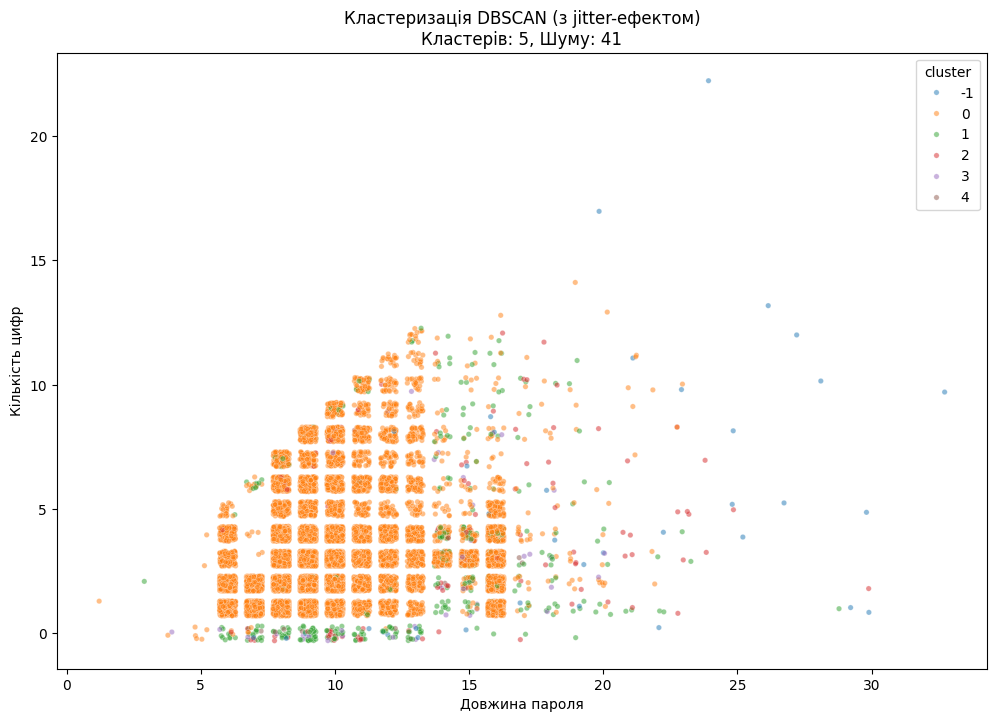

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(12, 8))

plot_data = df_sampled.copy()

plot_data['length_jitter'] = plot_data['length'] + np.random.uniform(-0.3, 0.3, size=len(plot_data))
plot_data['digits_jitter'] = plot_data['num_digits'] + np.random.uniform(-0.3, 0.3, size=len(plot_data))

sns.scatterplot(
    data=plot_data,
    x='length_jitter',
    y='digits_jitter',
    hue='cluster',
    palette='tab10',
    alpha=0.5,
    s=15,
    legend='full' if n_clusters <= 15 else False
)

plt.title(f'Кластеризація DBSCAN (з jitter-ефектом)\nКластерів: {n_clusters}, Шуму: {n_noise}')
plt.xlabel('Довжина пароля')
plt.ylabel('Кількість цифр')

plt.show()

На цьому етапі проводиться A/B-тестування для порівняння двох класифікаційних моделей: Логістичної Регресії (Модель A) та Random Forest (Модель B).

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

df_sampled['target'] = df_sampled.apply(lambda x: 1 if (x['length'] >= 10 and x['num_digits'] > 0) else 0, axis=1)

print("Розподіл класів (0 - слабкий, 1 - сильний):")
print(df_sampled['target'].value_counts())

X_train, X_test, y_train, y_test = train_test_split(X_subset_scaled, df_sampled['target'], test_size=0.3, random_state=42)

# --- МОДЕЛЬ A: Логістична Регресія (Проста) ---
model_a = LogisticRegression()
model_a.fit(X_train, y_train)
y_pred_a = model_a.predict(X_test)
acc_a = accuracy_score(y_test, y_pred_a)

# --- МОДЕЛЬ B: Random Forest (Складна) ---
model_b = RandomForestClassifier(n_estimators=100, random_state=42)
model_b.fit(X_train, y_train)
y_pred_b = model_b.predict(X_test)
acc_b = accuracy_score(y_test, y_pred_b)

print(f"Точність Моделі A (Logistic Regression): {acc_a:.4f} ({acc_a*100:.2f}%)")
print(f"Точність Моделі B (Random Forest):      {acc_b:.4f} ({acc_b*100:.2f}%)")

best_pred = y_pred_b if acc_b > acc_a else y_pred_a
print("\nДетальний звіт класифікації:")
print(classification_report(y_test, best_pred))

Розподіл класів (0 - слабкий, 1 - сильний):
target
0    10495
1     9505
Name: count, dtype: int64
Точність Моделі A (Logistic Regression): 0.9955 (99.55%)
Точність Моделі B (Random Forest):      1.0000 (100.00%)

Детальний звіт класифікації:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3220
           1       1.00      1.00      1.00      2780

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000



## Висновки
У рамках практичного заняття було успішно досліджено та застосовано два ключові методи машинного навчання: алгоритм кластеризації DBSCAN (Density-Based Spatial Clustering of Applications with Noise) та метод A/B-тестування.

Оскільки DBSCAN базується на щільності3, для роботи з великим датасетом паролів, що могло призвести до помилки OOM (Out of Memory), було проведено попереднє обмеження вибірки даних до 20,000 рядків. Це дозволило ефективно масштабувати числові ознаки (довжина, кількість цифр тощо) та уникнути ресурсних проблем. На етапі кластеризації було підтверджено, що DBSCAN успішно ідентифікує області високої щільності та позначає унікальні паролі як шумові точки з міткою -14444.

Було проведено порівняння двох моделей класифікації надійності паролів: Моделі A (Logistic Regression) та Моделі B (Random Forest). В результаті A/B-тестування модель Random Forest продемонструвала найвищу точність (Accuracy) 100.00%, перевершивши показник Logistic Regression (99.55%). Таким чином, було встановлено, що для класифікації надійності паролів слід обрати модель Random Forest, що повністю підтверджує вимогу щодо досягнення високої точності роботи алгоритму, необхідної для фінального висновку.